### Rag Using Langchain

In [1]:
import json
import pandas as pd
import re
import torch
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.llms import Ollama
from langchain.vectorstores import FAISS
from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
import numpy as np
import faiss
from langchain.docstore import InMemoryDocstore
import json
from langchain_community.vectorstores import FAISS

/Users/maryamsaad/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
top_k = 5
LLM_Model = Ollama(model='qwen3:8b', temperature=0.3, num_ctx=4096)

/var/folders/c2/f9lh6rmd4q1648_pfl1636zw0000gn/T/ipykernel_59209/824802379.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  LLM_Model = Ollama(model='qwen3:8b', temperature=0.3, num_ctx=4096)


In [3]:
def clean_text(text):
    """Clean text data"""
    text = str(text)
    text = re.sub(r'\n{3,}', '\n\n', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()
def chunks_text(text):
    """Split text into chunks."""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=200,
        chunk_overlap=30, length_function=lambda x: len(x.split()),
        separators=["\n\n\n", "\n\n", "\n", ". ", "! ", "? ", "; ", ", ", " ", ""],
        keep_separator=False,
        add_start_index=True,
        strip_whitespace=True
    )
    return text_splitter.split_text(text)


In [4]:
def load_and_preprocess_data(file_paths):
    """Load and preprocess data from multiple JSON files."""
    all_clean_texts = []
    for file_path in file_paths:
        with open(file_path, 'r') as f:
            raw_data = json.load(f)
        clean_texts = [clean_text(entry) for entry in raw_data if isinstance(entry, str)]
        all_clean_texts.extend(clean_texts) 

    combined_text = "\n".join(all_clean_texts)
    return Document(page_content=combined_text, metadata={"user_id": '001', "file_id": '01'})


document = load_and_preprocess_data(["Market Research Report_extracted_text.json", 'PMS Market Research_extracted_text.json'])


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=30, 
    length_function=lambda x: len(x.split()),
    separators=["\n\n\n", "\n\n", "\n", ". ", "! ", "? ", "; ", ", ", " ", ""],
    keep_separator=False,
    add_start_index=True,
    strip_whitespace=True
)
chunks = text_splitter.split_text(document.page_content)
print(f"Number of chunks: {len(chunks)}")

Number of chunks: 69


In [47]:
chunks[-2]

'Aconex excels in st ructured communication, transmittals, and formal document control, making it a go -to choice for large -scale infrastructure projects. PMWeb offers impressive breadth with strong cost control, scheduling, and portfolio -wide visibility, though it may come wit h a steeper learning curve.'

In [5]:
document

Document(metadata={'user_id': '001', 'file_id': '01'}, page_content='MARKET RESEARCH REPORT: ANALYSIS OF DOCUMENT TRANSLATION TOOLS Evaluating Leading Solutions for Multilingual Document Translation Mah inour Mohammad\nIntroduction This market research report analyzes competitors offering document translation tools that support PDF, Word, Excel, and scanned images while preserving layout and formatting. The focus is on tools that handle Arabic, French, and English languages, catering to both B2B and B2C markets. The key features evaluated include layout preservation, Arabic support and quality, translation accuracy and speed, pricing model, and Optical Character Recognition (OCR) support. To assess these tools, a series of test cases were conducted for each language, including: 1. Text -based documents: Evaluating basic translation accuracy, layout preservation, handling of number lists, bullet points, and right -to-left (RTL) and left -to-right (LTR) conversions. 2. Scanned documents:

In [6]:
chunks[:2]

['MARKET RESEARCH REPORT: ANALYSIS OF DOCUMENT TRANSLATION TOOLS Evaluating Leading Solutions for Multilingual Document Translation Mah inour Mohammad',
 'Introduction This market research report analyzes competitors offering document translation tools that support PDF, Word, Excel, and scanned images while preserving layout and formatting. The focus is on tools that handle Arabic, French, and English languages, catering to both B2B and B2C markets. The key features evaluated include layout preservation, Arabic support and quality, translation accuracy and speed, pricing model, and Optical Character Recognition (OCR) support. To assess these tools, a series of test cases were conducted for each language, including: 1. Text -based documents: Evaluating basic translation accuracy, layout preservation, handling of number lists, bullet points, and right -to-left (RTL) and left -to-right (LTR) conversions. 2. Scanned documents: Testing OCR performance, particularly for Arabic, and preservat

In [ ]:
device = 'mps' if torch.mps.is_available() else 'cpu'
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", model_kwargs={'device':device})


def batch_embed(texts, batch_size=64):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]
        batch_embeddings = embedding_model.embed_documents(batch)
        embeddings.extend(batch_embeddings)
    return np.array(embeddings, dtype=np.float32)

def create_vectorstore( chunks):
    """Create vector store from chunks."""
    docs = [
            Document(page_content=chunk, metadata={"user_id": '001', "file_id": '01'})
            for chunk in chunks
        ]
        
    texts = [doc.page_content for doc in docs]
    embeddings = batch_embed(texts)
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)  
    faiss.normalize_L2(embeddings)
    index.add(embeddings)
        
    docstore = InMemoryDocstore({str(i): doc for i, doc in enumerate(docs)})
    index_to_docstore_id = {i: str(i) for i in range(len(docs))}
        
    vectorstore = FAISS(
            embedding_function=embedding_model.embed_query,
            index=index,
            docstore=docstore,
            index_to_docstore_id=index_to_docstore_id
        )
        
  
    return vectorstore

In [ ]:
vector_store  = create_vectorstore(chunks)

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


In [9]:
def save_vectorstore(vector_store, directory_path):
    """Save vector store to a directory."""
    vector_store.save_local(directory_path)

def load_vectorstore(directory_path, embeddings):
    """Load vector store from a directory."""
    return FAISS.load_local(directory_path, embeddings)


In [10]:
def format_docs(docs):
    """Format documents for context"""
    return "\n\n".join(f"[Source {i}]: {doc.page_content}" for i, doc in enumerate(docs, 1))


def qa_chain():
    """Setup QA chain with custom prompts"""
    retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": top_k}
    )

    print("RETRIEVER is :", retriever)
    prompt_template = """You are a helpful assistant. Analyze the context and provide a structured response.

    Context:
    {context}

    Question: {question}

    Please provide your response in exactly this format:

    RESPONSE:
    [Your direct, concise answer to the question]

    REASONING:
    [Brief explanation of how you arrived at this answer using the sources]

    SOURCES:
    [List the source numbers that support your answer, e.g., 1, 2, 3]

    Important: Do not include any <think> tags or internal reasoning. Be direct and concise."""

    PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
    )

    qa_chain = (
    {
    "context": retriever | format_docs,
    "question": RunnablePassthrough()
    }
    | PROMPT
    | LLM_Model
    | StrOutputParser()
    )

    return qa_chain

In [24]:
def parse_structured_response(response_text):
    """Parse the structured response"""
    cleaned_response = re.sub(r'<think>.*?</think>', '', response_text, flags=re.DOTALL)
    cleaned_response = re.sub(r'<[^>]+>', '', cleaned_response)
    cleaned_response = re.sub(r'\n\s*\n', '\n\n', cleaned_response.strip())
        
    sections = {'response': '', 'reasoning': '', 'sources': ''}
    current_section = None
    current_content = []
        
    lines = cleaned_response.split('\n')
        
    for line in lines:
        line = line.strip()
            
        if line.upper().startswith('RESPONSE:'):
            if current_section:
                sections[current_section] = '\n'.join(current_content).strip()
            current_section = 'response'
            current_content = [line[9:].strip()]
                
        elif line.upper().startswith('REASONING:'):
            if current_section:
                sections[current_section] = '\n'.join(current_content).strip()
            current_section = 'reasoning'
            current_content = [line[10:].strip()]
                
        elif line.upper().startswith('SOURCES:'):
            if current_section:
                sections[current_section] = '\n'.join(current_content).strip()
            current_section = 'sources'
            current_content = [line[8:].strip()]
                
        elif current_section and line:
            current_content.append(line)
        
    if current_section:
        sections[current_section] = '\n'.join(current_content).strip()
        
    source_ids = []
    if sections['sources']:
        source_text = sections['sources']
        source_ids = [int(x) for x in re.findall(r'\d+', source_text)]
        
    return {
            'answer': sections['response'],
            'reasoning': sections['reasoning'],
            'sources': source_ids,
            'raw_response': cleaned_response
        }
    

In [25]:
def ask_question(question, return_sources=True):
    chain = qa_chain() 
    response = chain.invoke(question)
    parsed_response = parse_structured_response(response)

    if return_sources:
        retriever = vector_store.as_retriever(
            search_type="similarity",
            search_kwargs={"k": top_k}
        )
        source_docs = retriever.get_relevant_documents(question)
        parsed_response['answer'] = parsed_response['answer'].strip()
        parsed_response['reasoning'] = parsed_response['reasoning'].strip()
        parsed_response['sources'] = [int(x) for x in parsed_response['sources']]
        parsed_response['source_documents'] = source_docs
        parsed_response['source_texts'] = [doc.page_content for doc in source_docs]

    return parsed_response





In [28]:
vector_store, retriever = create_vectorstore(chunks)
response = ask_question("What are the key findings from the market research report?")
print(response['answer'])
print("\nReasoning:")
print(response['reasoning'])
print("\nSources:")
print(response['sources'])

`embedding_function` is expected to be an Embeddings object, support for passing in a function will soon be removed.


RETRIEVER is : tags=['FAISS'] vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x3843c47c0> search_kwargs={'k': 5}
The key findings from the market research report highlight that no single document translation tool fully meets all requirements for accurate, efficient, and cost-effective translation across Arabic, French, and English, particularly for preserving layout and handling OCR for scanned documents. Specific tools like Doctranslator excel in layout preservation but lack OCR, while others like Doclingo offer good OCR performance for Arabic but struggle with complex tables.

Reasoning:
The answer is derived from Source 3, which details the performance of tools like Doctranslator, Doctranslate.io, Doclingo, and DeepL, emphasizing their strengths and limitations. Source 1 provides context on the evaluation criteria and focus areas (layout preservation, OCR, multilingual support). Source 5 adds recommendations for improving tools, reinforcing the gap in current so

In [27]:
ask_question(" If you had to build a hybrid solution using two platforms from the research, which combination would you choose for a $50M solar project, \
                      and how would you handle the integration challenges, particularly around \
                      the 12 core features identified in the research?")

RETRIEVER is : tags=['FAISS'] vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x3834b4760> search_kwargs={'k': 5}


{'answer': 'Choose PMWeb and Procore. PMWeb handles project management workflows (approvals, role-based tasks, versioning), while Procore manages construction-specific tasks (submittals, bid handling). Integration via APIs ensures seamless data flow between document control, financial systems, and project tracking.',
 'reasoning': 'PMWeb (Sources 3, 4, 5) excels in role-based assignments, approval workflows, versioning, and financial integration, addressing core features like document approvals and contract management. Procore (Source 4) specializes in construction workflows (submittals, AI drawing management) and bid handling, which are critical for solar projects. Combining them covers both project management and solar-specific needs. Integration via APIs resolves challenges around version control, role-based tasks, and cross-platform data synchronization.',
 'sources': [3, 4, 5],
 'raw_response': 'RESPONSE:  \nChoose PMWeb and Procore. PMWeb handles project management workflows (app

### Summerize using map reduce

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate.from_messages([("human", reduce_template)])

# Initialize LLM_Model and output parser

output_parser = StrOutputParser()


map_chain = map_prompt | LLM_Model | output_parser
reduce_chain = reduce_prompt | LLM_Model | output_parser

# MAP STEP: Generate summaries for each chunk
def map_step(chunks):
    """Generate individual summaries for each chunk"""
    summaries = []
    for i, chunk in enumerate(chunks):
        print(f"Processing chunk {i+1}/{len(chunks)}")
        summary = map_chain.invoke({"context": chunk})
        summaries.append(summary)
    return summaries

# REDUCE STEP: Combine summaries into final summary
def reduce_step(summaries):
    """Combine all summaries into final consolidated summary"""
    # Join summaries with separators
    combined_summaries = "\n\n".join([f"Summary {i+1}: {summary}" for i, summary in enumerate(summaries)])
    
    # Generate final summary
    final_summary = reduce_chain.invoke({"docs": combined_summaries})
    return final_summary

In [31]:
print("Starting MAP step...")
chunk_summaries = map_step(chunks)

Starting MAP step...
Processing chunk 1/69
Processing chunk 2/69
Processing chunk 3/69
Processing chunk 4/69
Processing chunk 5/69
Processing chunk 6/69
Processing chunk 7/69
Processing chunk 8/69
Processing chunk 9/69
Processing chunk 10/69
Processing chunk 11/69
Processing chunk 12/69
Processing chunk 13/69
Processing chunk 14/69
Processing chunk 15/69
Processing chunk 16/69
Processing chunk 17/69
Processing chunk 18/69
Processing chunk 19/69
Processing chunk 20/69
Processing chunk 21/69
Processing chunk 22/69
Processing chunk 23/69
Processing chunk 24/69
Processing chunk 25/69
Processing chunk 26/69
Processing chunk 27/69
Processing chunk 28/69
Processing chunk 29/69
Processing chunk 30/69
Processing chunk 31/69
Processing chunk 32/69
Processing chunk 33/69
Processing chunk 34/69
Processing chunk 35/69
Processing chunk 36/69
Processing chunk 37/69
Processing chunk 38/69
Processing chunk 39/69
Processing chunk 40/69
Processing chunk 41/69
Processing chunk 42/69
Processing chunk 43/69

In [32]:
# Step 2: Reduce - Combine summaries
print("Starting REDUCE step...")
final_summary = reduce_step(chunk_summaries)

Starting REDUCE step...


In [33]:
print("Final Summary:")
print(final_summary)

Final Summary:
<think>
Okay, let's see. The user wants a concise summary of the feature matrix comparing five platforms. The main goal is to highlight strengths and weaknesses in each category. 

First, I need to recall the key points from the matrix. The platforms are Monday.com, Wrike, PMWeb, Aconex, and Procore. The features include role assignment, document approval workflow, versioning, markup versions, auto-changing status after submittals, financial oversight, bids management, DMS, dashboards, reporting, notifications, and project archiving.

From the data, PMWeb and Aconex are top in document approval workflows (100%). Wrike is strong in role assignment (85%) and dashboards (100%). Procore has high scores in bids management (+100%) and financial oversight (90%). Aconex leads in DMS (100%) and project archiving (100%), while Monday.com and Wrike lag in bids management (0%) and DMS (0%). 

I need to structure this into a clear summary. Start by mentioning the platforms and their 

### Stuff method

In [38]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(LLM_Model, prompt)

# Invoke chain with a list of Document objects
result = chain.invoke({"context": [document]})
print(result)

<think>
Okay, so I need to analyze this detailed comparison of project management platforms for the construction industry. Let me start by breaking down what each platform offers based on the information provided. 

First, the user mentioned platforms like Monday.com, Wrike, PMWeb, Aconex, and Procore. They also touched on renewable energy-focused tools like RaPM, SenseHawk, and Payaca, but those are more monitoring tools rather than project management systems. The main focus is on construction-specific needs.

Looking at the feature matrix, each platform is rated on 12 features. Let me go through each one:

1. **Assigning roles**: Monday.com is at 10%, which is low. Wrike is 85%, PMWeb 80%, Aconex 80%, Procore 80%. So Wrike and the others are better here. Maybe Monday.com lacks role-based task assignment.

2. **Document approval workflow**: All except Monday.com are 100% or 80% or 80%+. Wait, the matrix shows Monday.com at 60%, Wrike 100%, PMWeb 100%, Aconex 100%, Procore 100%. Wait, 

### Ready chain method

In [48]:
from langchain.chains.summarize import load_summarize_chain
from langchain_core.documents import Document
chain = load_summarize_chain(LLM_Model, chain_type="map_reduce", verbose=True)
if isinstance(chunks[0], str):
    chunked_docs = [Document(page_content=chunk) for chunk in chunks]
else:
    chunked_docs = chunks  


summary = chain.run(chunked_docs)



> Entering new MapReduceDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"MARKET RESEARCH REPORT: ANALYSIS OF DOCUMENT TRANSLATION TOOLS Evaluating Leading Solutions for Multilingual Document Translation Mah inour Mohammad"


CONCISE SUMMARY:
Prompt after formatting:
Write a concise summary of the following:


"Introduction This market research report analyzes competitors offering document translation tools that support PDF, Word, Excel, and scanned images while preserving layout and formatting. The focus is on tools that handle Arabic, French, and English languages, catering to both B2B and B2C markets. The key features evaluated include layout preservation, Arabic support and quality, translation accuracy and speed, pricing model, and Optical Character Recognition (OCR) support. To assess these tools, a series of test cases were conducted for each language, including: 1. Text -based documents: Evaluating

In [49]:
print("Summary:", summary)

Summary: <think>
Okay, the user wants a concise summary of the provided text. Let me read through the original content again to make sure I understand the key points.

The main points are about the features of a project management tool. The first part talks about task structuring, allowing project owners to assign tasks to roles without notifications and reassign them. Then there's a mention of communication panels for comments, mentions, and file sharing. The tool lacks a home feed, which is noted as a downside compared to Monday.com. The automation section highlights rule-based triggers for automating task assignments, status updates, and notifications.

I need to condense this into a short summary. Start by stating the task structuring and assignment features. Mention the communication tools and the absence of a home feed. Then include the automation capabilities. Keep it clear and to the point, avoiding any extra details. Make sure all key elements are included without being too ve

In [42]:
stuff_chain = load_summarize_chain(LLM_Model, chain_type="stuff", verbose=True)
stuff_summary = stuff_chain.run(chunked_docs)



> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"MARKET RESEARCH REPORT: ANALYSIS OF DOCUMENT TRANSLATION TOOLS Evaluating Leading Solutions for Multilingual Document Translation Mah inour Mohammad

Introduction This market research report analyzes competitors offering document translation tools that support PDF, Word, Excel, and scanned images while preserving layout and formatting. The focus is on tools that handle Arabic, French, and English languages, catering to both B2B and B2C markets. The key features evaluated include layout preservation, Arabic support and quality, translation accuracy and speed, pricing model, and Optical Character Recognition (OCR) support. To assess these tools, a series of test cases were conducted for each language, including: 1. Text -based documents: Evaluating basic translation accuracy, layout preservation, handling of number lists, bullet points, an

In [43]:
print(stuff_summary)

<think>
Okay, the user wants a concise summary of the comparison between Monday.com, Wrike, PMWeb, Aconex, and Procore for project management, especially in the construction and renewable energy sectors. Let me start by recalling the key points from the detailed analysis provided.

First, Monday.com and Wrike are general-purpose tools with good task tracking and dashboards but lack construction-specific features like submittal tracking and OCR. PMWeb is strong in cost control and scheduling but has a steeper learning curve. Aconex is great for structured communication and document control, ideal for large infrastructure. Procore excels in construction-specific tools like automated submittals and AI drawing management. The renewable energy platforms like RaPM are more for monitoring than project management.

I need to highlight the strengths and weaknesses of each platform, focusing on the features that matter for construction projects. Also, mention the renewable energy tools as they a

In [45]:
ask_question("Which translator charges users with credits?")

RETRIEVER is : tags=['FAISS'] vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x3843c47c0> search_kwargs={'k': 5}


{'answer': 'Doctranslate.io',
 'reasoning': 'Source 1 explicitly describes Doctranslate.io\'s pricing model, which uses translation credits (e.g., "Topup -50 $4.99 50 translation credit") and annual subscriptions with credit allocations. Other tools mentioned in sources 2, 3, and 5 use character limits or file-based pricing, not credit systems.',
 'sources': [1, 5],
 'raw_response': 'RESPONSE:  \nDoctranslate.io  \n\nREASONING:  \nSource 1 explicitly describes Doctranslate.io\'s pricing model, which uses translation credits (e.g., "Topup -50 $4.99 50 translation credit") and annual subscriptions with credit allocations. Other tools mentioned in sources 2, 3, and 5 use character limits or file-based pricing, not credit systems.  \n\nSOURCES:  \n1, 5',
 'source_documents': [Document(metadata={'user_id': '001', 'file_id': '01'}, page_content='Pricing Plans for Paid Tool s Tool Plan Name Cost Key Features Benefits Notes Doctranslate.io Topup -50 $4.99 50 translation credit • 10 cent/ page 

In [44]:
refine_chain = load_summarize_chain(LLM_Model, chain_type="refine", verbose=True)
refine_summary = refine_chain.run(chunked_docs)



> Entering new RefineDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Write a concise summary of the following:


"MARKET RESEARCH REPORT: ANALYSIS OF DOCUMENT TRANSLATION TOOLS Evaluating Leading Solutions for Multilingual Document Translation Mah inour Mohammad"


CONCISE SUMMARY:

> Finished chain.


> Entering new LLMChain chain...
Prompt after formatting:
Your job is to produce a final summary.
We have provided an existing summary up to a certain point: <think>
Okay, the user wants a concise summary of a market research report titled "Analysis of Document Translation Tools: Evaluating Leading Solutions for Multilingual Document Translation by Mah inour Mohammad." Let me start by understanding the key elements here.

First, the report's main focus is on document translation tools. The title mentions evaluating leading solutions for multilingual translation, so the summary should highlight the purpose of the analysis. The author is Mah inour Moha

KeyboardInterrupt: 

In [ ]:
print("refine_summary:", refine_summary)

In [ ]:
# COMPARISON OF CHAIN TYPES:
# =========================
# 
# "stuff": 
#   - Fastest, simplest
#   - Good for small documents
#   - Concatenates all chunks into one prompt
#   - May hit token limits with large documents
#
# "map_reduce":
#   - Best for large documents
#   - Parallel processing of chunks
#   - Summarizes each chunk, then combines summaries
#   - Your case: good for many chunks
#
# "refine":
#   - Iterative improvement
#   - Processes chunks sequentially
#   - Each summary builds on the previous one
#   - Good for maintaining context across chunks

### Mapreduce LangGraph implementation

In [56]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(LLM_Model.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    response = await map_chain.ainvoke(state["content"])
    return {"summaries": [response]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, reduce_chain.ainvoke))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await reduce_chain.ainvoke(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

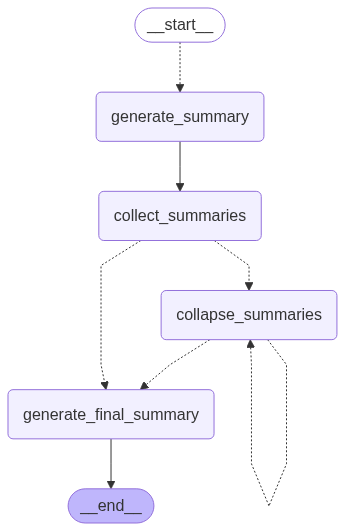

In [57]:
app

In [ ]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in chunked_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
